In [1]:
import pickle as pkl
import re
import random
import os
import numpy as np
from collections import Counter
from sklearn.feature_extraction import stop_words
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from collections import Counter

max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens,max_vocab_size = 10000 ):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token


def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [3]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0) #stores embeddings of a fixed dictionary and size
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out



In [5]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [6]:
def data_loader(n_gram, max_vocab_size = 10000):
    train_data_tokens = pkl.load(open('tokens/train_set_tokens_%s_gram.p' % n_gram, "rb"))
    all_train_tokens = pkl.load(open('tokens/all_train_tokens_%s_gram.p' % n_gram, "rb"))
    val_data_tokens = pkl.load(open('tokens/val_set_tokens_%s_gram.p' % n_gram, "rb"))
    test_data_tokens = pkl.load(open('tokens/test_set_tokens_%s_gram.p' % n_gram, "rb"))

    train_label = pkl.load(open('tokens/train_labels.p', "rb"))
    val_label = pkl.load(open('tokens/val_labels.p' , "rb"))
    test_label = pkl.load(open('tokens/test_labels.p' , "rb"))

    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
    train_data_indices = token2index_dataset(train_data_tokens, token2id)
    val_data_indices = token2index_dataset(val_data_tokens, token2id)
    test_data_indices = token2index_dataset(test_data_tokens, token2id)
    BATCH_SIZE = 32
    train_dataset = NewsGroupDataset(train_data_indices, train_label)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_label)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_label)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    return train_loader, val_loader, test_loader

In [22]:
def compare_model(train_loader, val_loader, test_loader,
                  num_epochs = 5, emb_dim = 500, vocab_size = 10002, learning_rate = 0.001, 
                  optimizer_name = 'Adam', momentum = 0.9, annealing_learing = False, 
                  print_ = True, model_del = True ):

    model = BagOfWords(vocab_size, emb_dim)

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum)
    else: 
        return('Wrong Optimizer')
    
    if annealing_learing:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    val_history = []  
    train_history = []
    for epoch in range(num_epochs):
        if annealing_learing:
            scheduler.step()
            
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                train_acc = test_model(train_loader, model)
                val_acc = test_model(val_loader, model)
                val_history.append(val_acc)
                train_history.append(train_acc)
                
                if print_:
                    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            
                
    test_acc = test_model(test_loader, model)
    if model_del:
        del(model)
    return train_history, val_history, test_acc

In [8]:
n_grams = [1, 2, 3, 4]
vocab_sizes = [10002, 50000, 100000]
embed_dims = [100, 200, 500 ]
learning_rates = [0.01, 0.05, 0.001, 0.0001]
optimizers = ['Adam', 'SGD']
momentums = [0.1, 0.5, 0.9]

### plot the history of train acc and val acc

In [94]:
import pickle as pkl
table= {}
train_loader, val_loader, test_loader = data_loader(1)
train_history, val_history, test_acc = compare_model(train_loader, val_loader, test_loader )
table['val_history'] = val_history
table['train_history'] = train_history
pkl.dump(table, open('accuracy/n_gram_acc_history.p', 'wb'))

Epoch: [1/5], Step: [101/625], Validation Acc: 64.06
Epoch: [1/5], Step: [201/625], Validation Acc: 71.64
Epoch: [1/5], Step: [301/625], Validation Acc: 74.9
Epoch: [1/5], Step: [401/625], Validation Acc: 78.74
Epoch: [1/5], Step: [501/625], Validation Acc: 80.92
Epoch: [1/5], Step: [601/625], Validation Acc: 82.04
Epoch: [2/5], Step: [101/625], Validation Acc: 83.26
Epoch: [2/5], Step: [201/625], Validation Acc: 83.92
Epoch: [2/5], Step: [301/625], Validation Acc: 84.4
Epoch: [2/5], Step: [401/625], Validation Acc: 84.38
Epoch: [2/5], Step: [501/625], Validation Acc: 85.18
Epoch: [2/5], Step: [601/625], Validation Acc: 85.36
Epoch: [3/5], Step: [101/625], Validation Acc: 85.9
Epoch: [3/5], Step: [201/625], Validation Acc: 86.02
Epoch: [3/5], Step: [301/625], Validation Acc: 86.28
Epoch: [3/5], Step: [401/625], Validation Acc: 86.46
Epoch: [3/5], Step: [501/625], Validation Acc: 86.76
Epoch: [3/5], Step: [601/625], Validation Acc: 86.86
Epoch: [4/5], Step: [101/625], Validation Acc: 86

In [107]:
print(pd.DataFrame(table))

    train_history  val_history
0          63.835        64.06
1          72.265        71.64
2          76.005        74.90
3          80.400        78.74
4          82.640        80.92
5          84.310        82.04
6          85.750        83.26
7          86.850        83.92
8          87.695        84.40
9          87.375        84.38
10         89.015        85.18
11         89.440        85.36
12         90.135        85.90
13         90.410        86.02
14         90.565        86.28
15         91.145        86.46
16         91.495        86.76
17         91.850        86.86
18         92.010        86.60
19         92.320        86.92
20         92.575        86.84
21         92.880        87.06
22         93.260        87.10
23         93.325        87.16
24         93.680        87.38
25         93.445        87.12
26         93.745        87.28
27         94.185        87.18
28         94.370        87.20
29         94.335        87.02


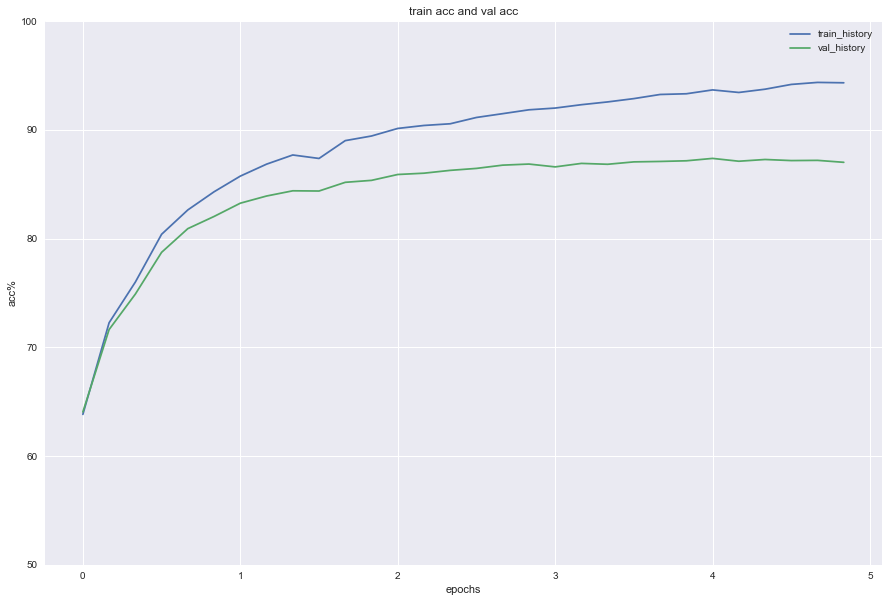

In [104]:
sns.set()
fig,ax=plt.subplots(figsize=(15,10))
l=locals()

x = np.arange(0 , 5, 1/6).reshape(-1,1)
for i in table.keys():
    l[i],=ax.plot(x, table[i], label=i)

ax.legend(loc = 'best')
plt.title('train acc and val acc')
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50,100)
plt.savefig('figure/n_gram_acc_history.jpg')
plt.show()

### Compare Epochs

In [114]:
epochs = [5, 10, 15, 20]
table= {}
train_loader, val_loader, test_loader = data_loader(1)
for i in epochs:
    print('epochs:', i)
    train_history, val_history, test_acc = compare_model(train_loader, val_loader, test_loader, num_epochs = i )
    table[i] = val_history

epochs: 5
Epoch: [1/5], Step: [101/625], Validation Acc: 62.04
Epoch: [1/5], Step: [201/625], Validation Acc: 71.3
Epoch: [1/5], Step: [301/625], Validation Acc: 74.68
Epoch: [1/5], Step: [401/625], Validation Acc: 78.06
Epoch: [1/5], Step: [501/625], Validation Acc: 79.3
Epoch: [1/5], Step: [601/625], Validation Acc: 80.28
Epoch: [2/5], Step: [101/625], Validation Acc: 83.02
Epoch: [2/5], Step: [201/625], Validation Acc: 83.74
Epoch: [2/5], Step: [301/625], Validation Acc: 84.42
Epoch: [2/5], Step: [401/625], Validation Acc: 84.94
Epoch: [2/5], Step: [501/625], Validation Acc: 85.62
Epoch: [2/5], Step: [601/625], Validation Acc: 85.6
Epoch: [3/5], Step: [101/625], Validation Acc: 86.38
Epoch: [3/5], Step: [201/625], Validation Acc: 86.5
Epoch: [3/5], Step: [301/625], Validation Acc: 86.62
Epoch: [3/5], Step: [401/625], Validation Acc: 86.76
Epoch: [3/5], Step: [501/625], Validation Acc: 86.48
Epoch: [3/5], Step: [601/625], Validation Acc: 86.7
Epoch: [4/5], Step: [101/625], Validation

In [115]:
pkl.dump(table, open('accuracy/compare_epochs.p', "wb"))

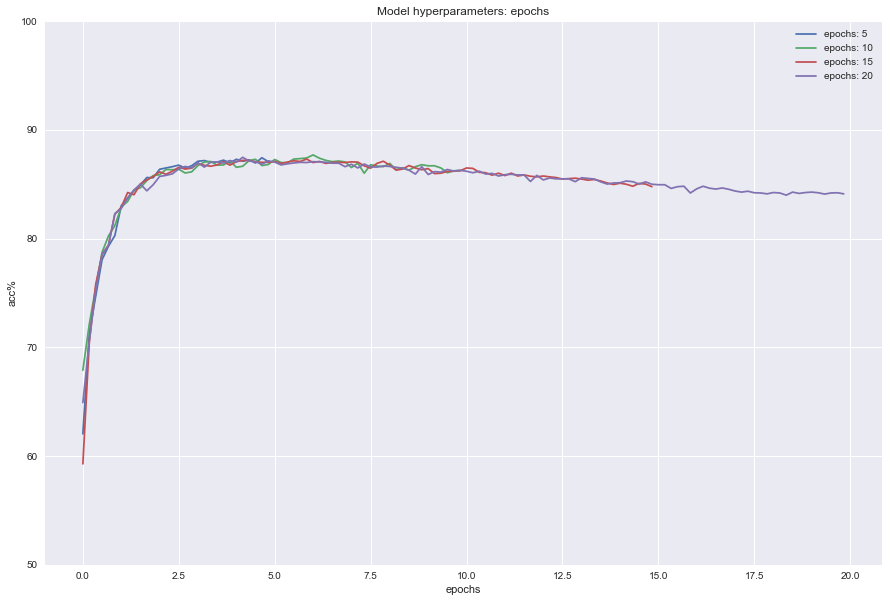

In [118]:
sns.set()
fig,ax=plt.subplots(figsize=(15,10))
l=locals()

x = np.arange(0 , 20, 1/6).reshape(-1,1)

for n in epochs:
    y = table[n]
    label = "epochs: "+str(n)
    l[label],=ax.plot(x[:len(y)], y, label=label)
ax.legend(loc = 'best')
plt.title('Model hyperparameters: epochs')
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50,100)
plt.savefig('figure/epochs_acc.jpg')

plt.show()

### Compare n-gram

In [9]:
table= {}

for i in n_grams:
    print('n_gram:%s'%i)
    train_loader, val_loader, test_loader = data_loader(i)
    train_history, val_history, test_acc = compare_model(train_loader, val_loader, test_loader )
    table[i] = val_history

n_gram:1
Epoch: [1/5], Step: [101/625], Validation Acc: 65.94
Epoch: [1/5], Step: [201/625], Validation Acc: 71.64
Epoch: [1/5], Step: [301/625], Validation Acc: 75.2
Epoch: [1/5], Step: [401/625], Validation Acc: 77.7
Epoch: [1/5], Step: [501/625], Validation Acc: 80.5
Epoch: [1/5], Step: [601/625], Validation Acc: 82.46
Epoch: [2/5], Step: [101/625], Validation Acc: 83.3
Epoch: [2/5], Step: [201/625], Validation Acc: 83.62
Epoch: [2/5], Step: [301/625], Validation Acc: 84.68
Epoch: [2/5], Step: [401/625], Validation Acc: 84.7
Epoch: [2/5], Step: [501/625], Validation Acc: 85.48
Epoch: [2/5], Step: [601/625], Validation Acc: 85.56
Epoch: [3/5], Step: [101/625], Validation Acc: 85.8
Epoch: [3/5], Step: [201/625], Validation Acc: 86.14
Epoch: [3/5], Step: [301/625], Validation Acc: 85.96
Epoch: [3/5], Step: [401/625], Validation Acc: 86.34
Epoch: [3/5], Step: [501/625], Validation Acc: 86.62
Epoch: [3/5], Step: [601/625], Validation Acc: 86.72
Epoch: [4/5], Step: [101/625], Validation A

In [10]:
pkl.dump(table, open('accuracy/compare_n_gram.p', "wb"))

In [11]:
print(pd.DataFrame(table))

        1      2      3      4
0   65.94  64.58  61.76  50.32
1   71.64  68.34  64.06  66.32
2   75.20  73.26  71.64  73.66
3   77.70  76.38  76.40  73.78
4   80.50  78.32  78.62  77.44
5   82.46  80.48  80.46  76.42
6   83.30  81.18  82.32  81.96
7   83.62  81.98  80.60  81.72
8   84.68  82.46  83.12  83.26
9   84.70  83.30  83.54  83.88
10  85.48  84.00  83.64  83.78
11  85.56  84.08  84.26  84.26
12  85.80  84.76  84.42  84.56
13  86.14  84.82  84.74  85.08
14  85.96  84.58  84.98  85.28
15  86.34  85.46  84.88  84.54
16  86.62  85.34  84.92  85.26
17  86.72  85.74  85.74  85.30
18  86.94  86.02  85.36  85.58
19  86.96  85.86  85.30  85.48
20  87.00  86.06  85.24  85.68
21  87.12  85.60  85.64  85.36
22  87.26  86.48  85.64  85.64
23  87.20  86.24  86.04  86.12
24  86.78  86.24  85.88  85.58
25  86.94  86.36  85.94  85.92
26  86.40  86.28  85.84  85.78
27  87.18  85.78  85.86  85.68
28  87.22  86.28  85.84  85.92
29  87.20  86.20  85.82  85.96


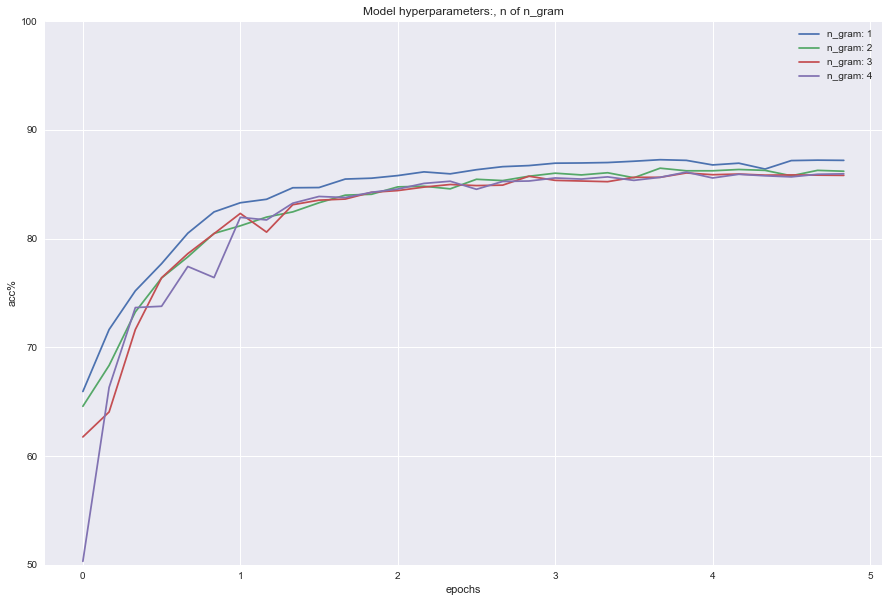

In [13]:
sns.set()
fig,ax=plt.subplots(figsize=(15,10))
lines=locals()

x = np.arange(0 , 5, 1/6).reshape(-1,1)

for n in n_grams:
    y = table[n]
    label = "n_gram: "+str(n)
    lines[label],=ax.plot(x, y, label=label)
ax.legend(loc = 'best')
plt.title('Model hyperparameters:, n of n_gram')
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50,100)
plt.savefig('figure/n_gram_acc.jpg')

plt.show()

### Compare Vocabulary size

In [119]:
vocab_sizes = [10002, 50000, 100000]
table = {}
train_loader, val_loader, test_loader = data_loader(1)
for i in vocab_sizes:
    print('vocabulary size:', i)
    train_history, val_history, test_acc = compare_model(train_loader, val_loader, test_loader, vocab_size = i )
    table[i] = val_history

vocabulary size: 10002
Epoch: [1/5], Step: [101/625], Validation Acc: 65.22
Epoch: [1/5], Step: [201/625], Validation Acc: 68.96
Epoch: [1/5], Step: [301/625], Validation Acc: 73.6
Epoch: [1/5], Step: [401/625], Validation Acc: 78.86
Epoch: [1/5], Step: [501/625], Validation Acc: 79.86
Epoch: [1/5], Step: [601/625], Validation Acc: 81.94
Epoch: [2/5], Step: [101/625], Validation Acc: 83.56
Epoch: [2/5], Step: [201/625], Validation Acc: 83.84
Epoch: [2/5], Step: [301/625], Validation Acc: 84.26
Epoch: [2/5], Step: [401/625], Validation Acc: 83.8
Epoch: [2/5], Step: [501/625], Validation Acc: 85.0
Epoch: [2/5], Step: [601/625], Validation Acc: 85.42
Epoch: [3/5], Step: [101/625], Validation Acc: 85.8
Epoch: [3/5], Step: [201/625], Validation Acc: 86.1
Epoch: [3/5], Step: [301/625], Validation Acc: 85.86
Epoch: [3/5], Step: [401/625], Validation Acc: 86.66
Epoch: [3/5], Step: [501/625], Validation Acc: 86.84
Epoch: [3/5], Step: [601/625], Validation Acc: 86.9
Epoch: [4/5], Step: [101/625]

In [120]:
pkl.dump(table, open('accuracy/compare_vocab_size.p', "wb"))

In [121]:
print(pd.DataFrame(table))

    10002   50000   100000
0    65.22   66.36   60.74
1    68.96   69.74   71.58
2    73.60   74.82   74.92
3    78.86   78.44   77.92
4    79.86   80.08   80.60
5    81.94   81.68   82.40
6    83.56   82.86   83.60
7    83.84   83.62   84.34
8    84.26   84.38   84.52
9    83.80   84.88   85.04
10   85.00   85.66   84.82
11   85.42   85.88   85.42
12   85.80   85.66   85.56
13   86.10   86.06   85.88
14   85.86   85.54   86.18
15   86.66   85.92   86.32
16   86.84   85.08   86.60
17   86.90   86.42   86.60
18   87.16   86.74   86.96
19   86.82   86.62   87.04
20   87.22   86.62   87.18
21   86.88   86.94   87.06
22   86.70   86.94   86.76
23   87.06   87.12   86.90
24   87.28   87.08   87.28
25   86.84   87.46   87.20
26   86.94   87.08   87.24
27   87.06   87.04   86.48
28   87.26   87.16   87.38
29   86.88   87.32   86.98


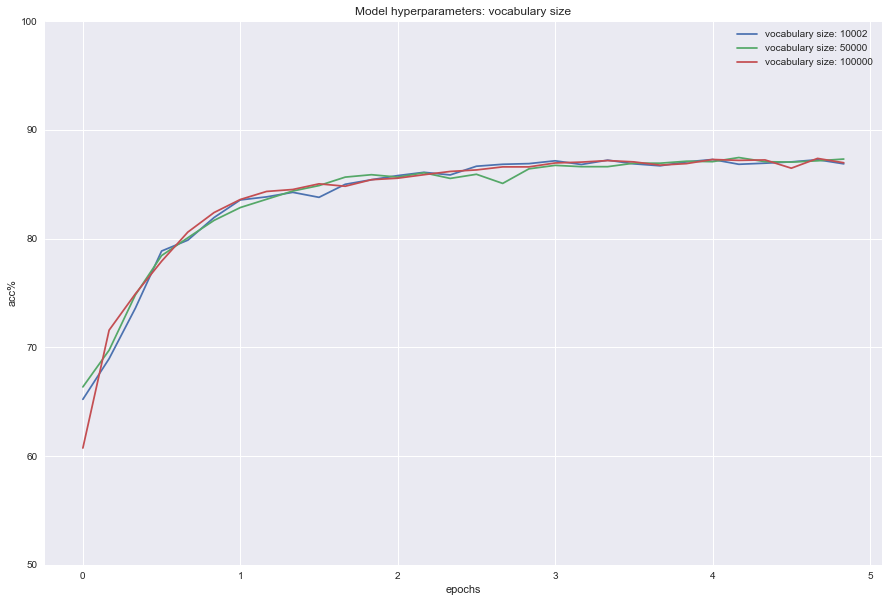

In [134]:
sns.set()
fig,ax=plt.subplots(figsize=(15,10))
l=locals()

x = np.arange(0 , 5, 1/6).reshape(-1,1)

for n in vocab_sizes:
    y = table[n]
    label = "vocabulary size: "+str(n)
    l[label], = ax.plot(x, y, label=label)
    
ax.legend(loc = 'best')
plt.title('Model hyperparameters: vocabulary size')
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50,100)

plt.savefig('figure/vocab_acc.jpg')

plt.show()

### Compare embedding size

In [123]:
embed_dims = [100, 200, 500]

table= {}
train_loader, val_loader, test_loader = data_loader(1)

for i in embed_dims:
    print('embedding dim:', i)
    train_history, val_history, test_acc = compare_model(train_loader, val_loader, test_loader, emb_dim = i )
    table[i] = val_history
  

embedding dim: 100
Epoch: [1/5], Step: [101/625], Validation Acc: 55.06
Epoch: [1/5], Step: [201/625], Validation Acc: 55.8
Epoch: [1/5], Step: [301/625], Validation Acc: 62.96
Epoch: [1/5], Step: [401/625], Validation Acc: 66.34
Epoch: [1/5], Step: [501/625], Validation Acc: 69.48
Epoch: [1/5], Step: [601/625], Validation Acc: 71.94
Epoch: [2/5], Step: [101/625], Validation Acc: 75.28
Epoch: [2/5], Step: [201/625], Validation Acc: 77.18
Epoch: [2/5], Step: [301/625], Validation Acc: 78.98
Epoch: [2/5], Step: [401/625], Validation Acc: 80.34
Epoch: [2/5], Step: [501/625], Validation Acc: 81.46
Epoch: [2/5], Step: [601/625], Validation Acc: 82.26
Epoch: [3/5], Step: [101/625], Validation Acc: 83.06
Epoch: [3/5], Step: [201/625], Validation Acc: 83.44
Epoch: [3/5], Step: [301/625], Validation Acc: 83.64
Epoch: [3/5], Step: [401/625], Validation Acc: 84.16
Epoch: [3/5], Step: [501/625], Validation Acc: 84.44
Epoch: [3/5], Step: [601/625], Validation Acc: 84.9
Epoch: [4/5], Step: [101/625]

In [124]:
pkl.dump(table, open('accuracy/compare_emb_dim.p', "wb"))

In [125]:
print(pd.DataFrame(table))

      100    200    500
0   55.06  56.36  62.00
1   55.80  60.06  72.04
2   62.96  68.92  75.92
3   66.34  73.44  78.78
4   69.48  76.28  81.02
5   71.94  77.92  81.62
6   75.28  79.34  82.50
7   77.18  80.98  83.38
8   78.98  81.72  84.34
9   80.34  82.62  84.42
10  81.46  83.58  85.46
11  82.26  83.50  84.52
12  83.06  84.48  85.62
13  83.44  84.40  86.24
14  83.64  85.10  86.20
15  84.16  85.34  86.62
16  84.44  85.40  85.48
17  84.90  85.82  86.56
18  85.04  85.82  86.62
19  85.20  86.38  86.60
20  85.60  86.58  87.08
21  85.82  86.64  86.92
22  86.18  86.66  86.88
23  85.90  87.16  87.18
24  86.04  86.10  86.70
25  86.06  87.14  87.24
26  85.80  86.84  87.12
27  85.86  87.24  86.24
28  86.40  87.20  87.22
29  86.54  87.22  87.02


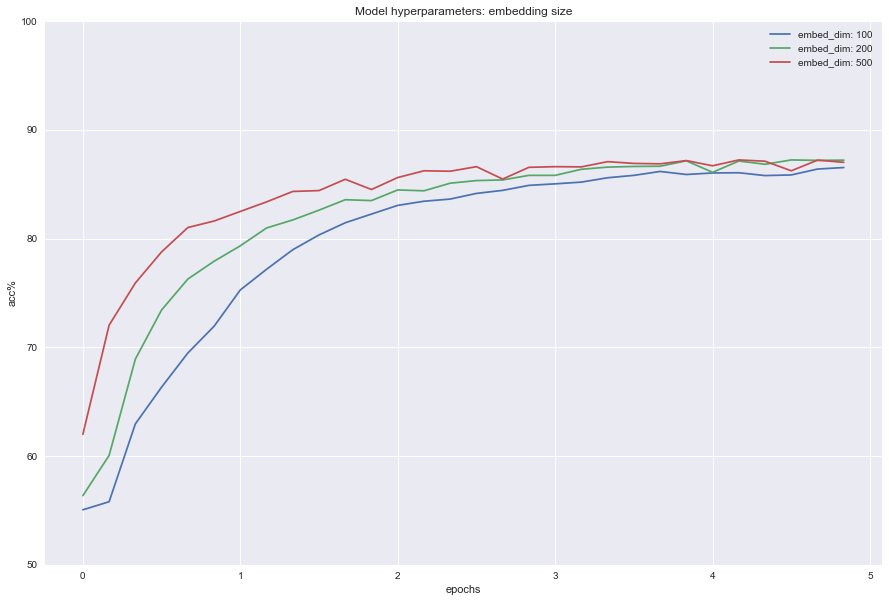

In [138]:
sns.set()
fig, ax = plt.subplots(figsize=(15,10))
l=locals()

x = np.arange(0 , 5, 1/6).reshape(-1,1)
for n in embed_dims:
    y = table[n]
    label = "embed_dim: "+str(n)
    l[label],=ax.plot(x, y, label=label)
    
ax.legend(loc = 'best')
plt.title('Model hyperparameters: embedding size')
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50,100)
plt.savefig('figure/emb_acc.jpg')

plt.show()

### Comapre Optimizers

In [108]:
optimizers = ['Adam', 'SGD']
train_loader, val_loader, test_loader = data_loader(1)
table= {}
momentums = [0.1, 0.5, 0.9]
for opt in optimizers:
    print('optimizer:', opt)
    if opt == 'SGD':
        for mon in momentums:
            train_history, val_history, test_acc = compare_model(train_loader, val_loader, test_loader, optimizer_name = opt, momentum = mon )
            name = opt+'_'+str(mon)
            table[name] = val_history     
    else:
        train_history, val_history, test_acc = compare_model(train_loader, val_loader, test_loader, optimizer_name = opt)
        table[opt] = val_history
    

optimizer: Adam
Epoch: [1/5], Step: [101/625], Validation Acc: 58.24
Epoch: [1/5], Step: [201/625], Validation Acc: 69.3
Epoch: [1/5], Step: [301/625], Validation Acc: 74.92
Epoch: [1/5], Step: [401/625], Validation Acc: 78.46
Epoch: [1/5], Step: [501/625], Validation Acc: 81.06
Epoch: [1/5], Step: [601/625], Validation Acc: 82.0
Epoch: [2/5], Step: [101/625], Validation Acc: 82.82
Epoch: [2/5], Step: [201/625], Validation Acc: 83.98
Epoch: [2/5], Step: [301/625], Validation Acc: 84.22
Epoch: [2/5], Step: [401/625], Validation Acc: 84.62
Epoch: [2/5], Step: [501/625], Validation Acc: 85.2
Epoch: [2/5], Step: [601/625], Validation Acc: 85.7
Epoch: [3/5], Step: [101/625], Validation Acc: 85.72
Epoch: [3/5], Step: [201/625], Validation Acc: 86.14
Epoch: [3/5], Step: [301/625], Validation Acc: 86.26
Epoch: [3/5], Step: [401/625], Validation Acc: 86.62
Epoch: [3/5], Step: [501/625], Validation Acc: 86.42
Epoch: [3/5], Step: [601/625], Validation Acc: 86.7
Epoch: [4/5], Step: [101/625], Vali

In [109]:
print(pd.DataFrame(table))

     Adam  SGD_0.1  SGD_0.5  SGD_0.9
0   58.24    49.08    52.66    56.14
1   69.30    49.30    53.60    58.52
2   74.92    49.50    54.92    62.26
3   78.46    50.20    55.06    63.68
4   81.06    51.02    56.12    64.70
5   82.00    51.80    58.48    64.26
6   82.82    53.36    59.16    66.32
7   83.98    53.66    60.12    65.16
8   84.22    54.70    60.16    66.72
9   84.62    55.54    60.84    67.00
10  85.20    56.12    62.12    65.68
11  85.70    55.88    61.14    67.66
12  85.72    57.02    62.32    67.86
13  86.14    57.64    62.28    67.64
14  86.26    57.26    62.92    66.96
15  86.62    57.92    62.72    67.96
16  86.42    58.36    62.10    68.72
17  86.70    58.38    63.28    68.62
18  87.02    58.94    63.52    68.78
19  86.80    58.96    63.62    68.90
20  86.96    59.96    63.84    69.46
21  86.84    59.58    63.68    69.52
22  87.00    59.96    63.74    69.50
23  87.02    60.22    63.98    69.60
24  86.96    60.52    64.34    69.78
25  86.76    61.30    64.20    69.84
2

In [110]:
pkl.dump(table, open('accuracy/compare_optimizer.p', "wb"))

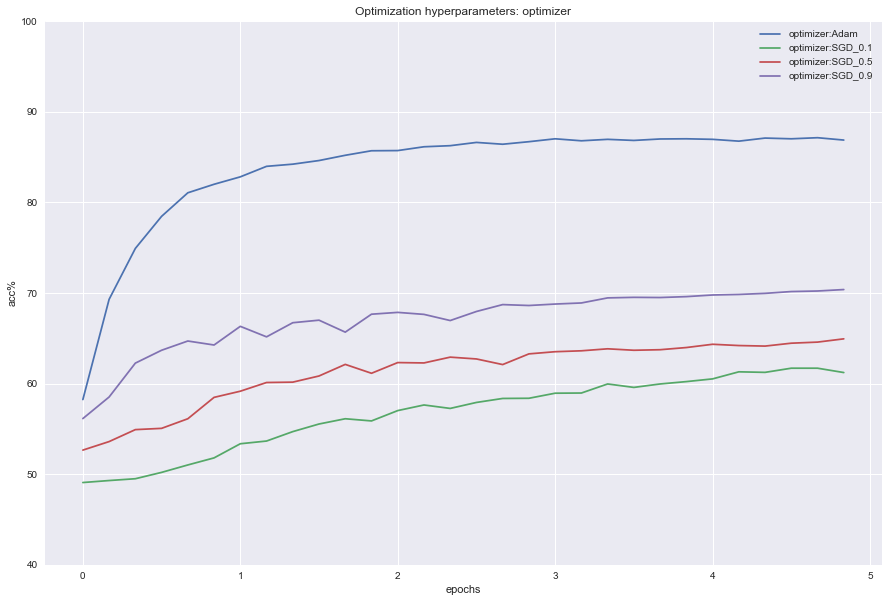

In [113]:
sns.set()
fig, ax = plt.subplots(figsize=(15,10))
l = locals()

x = np.arange(0 , 5, 1/6).reshape(-1,1)
for opt in table.keys():
    y = table[opt]
    label = 'optimizer:'+str(opt)
    l[label], = ax.plot(x, y, label = label)
    
ax.legend(loc = 'best')
plt.title('Optimization hyperparameters: optimizer')
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(40,100)
plt.savefig('figure/opt_acc.jpg')

plt.show()

### Compare Learning Rate

In [127]:
learning_rates = [0.01, 0.05, 0.001, 0.0001]
annealing = [True, False]

train_loader, val_loader, test_loader = data_loader(1)
table= {}
for lr in learning_rates:
    for an_lr in annealing:
        print('learning rate:', lr, 'annealing_learing:', an_lr)
        train_history, val_history, test_acc = compare_model(train_loader, val_loader, test_loader, learning_rate = lr, annealing_learing = an_lr )
        name = str(lr)+','+str(an_lr)
        table[name] = val_history

learning rate: 0.01 annealing_learing: True
Epoch: [1/5], Step: [101/625], Validation Acc: 79.62
Epoch: [1/5], Step: [201/625], Validation Acc: 83.36
Epoch: [1/5], Step: [301/625], Validation Acc: 84.44
Epoch: [1/5], Step: [401/625], Validation Acc: 84.24
Epoch: [1/5], Step: [501/625], Validation Acc: 83.62
Epoch: [1/5], Step: [601/625], Validation Acc: 85.78
Epoch: [2/5], Step: [101/625], Validation Acc: 86.34
Epoch: [2/5], Step: [201/625], Validation Acc: 85.26
Epoch: [2/5], Step: [301/625], Validation Acc: 86.2
Epoch: [2/5], Step: [401/625], Validation Acc: 85.86
Epoch: [2/5], Step: [501/625], Validation Acc: 85.42
Epoch: [2/5], Step: [601/625], Validation Acc: 84.44
Epoch: [3/5], Step: [101/625], Validation Acc: 84.56
Epoch: [3/5], Step: [201/625], Validation Acc: 85.24
Epoch: [3/5], Step: [301/625], Validation Acc: 85.34
Epoch: [3/5], Step: [401/625], Validation Acc: 85.34
Epoch: [3/5], Step: [501/625], Validation Acc: 84.84
Epoch: [3/5], Step: [601/625], Validation Acc: 85.48
Epo

In [128]:
print(pd.DataFrame(table))

    0.0001,False  0.0001,True  0.001,False  0.001,True  0.01,False  0.01,True  \
0          54.12        54.02        63.38       67.08       81.30      79.62   
1          56.82        55.64        69.26       71.88       84.22      83.36   
2          58.24        56.86        75.46       76.14       84.58      84.44   
3          60.64        57.52        78.26       78.78       86.06      84.24   
4          63.56        57.78        80.12       81.42       84.40      83.62   
5          65.62        61.56        80.90       82.22       86.52      85.78   
6          67.40        63.64        82.92       83.22       86.54      86.34   
7          67.62        65.08        83.68       83.18       86.38      85.26   
8          68.06        65.08        84.36       84.74       85.48      86.20   
9          68.74        66.60        84.66       84.92       86.10      85.86   
10         69.24        67.58        85.08       85.42       86.22      85.42   
11         69.50        67.7

In [129]:
pkl.dump(table, open('accuracy/compare_lr.p', "wb"))

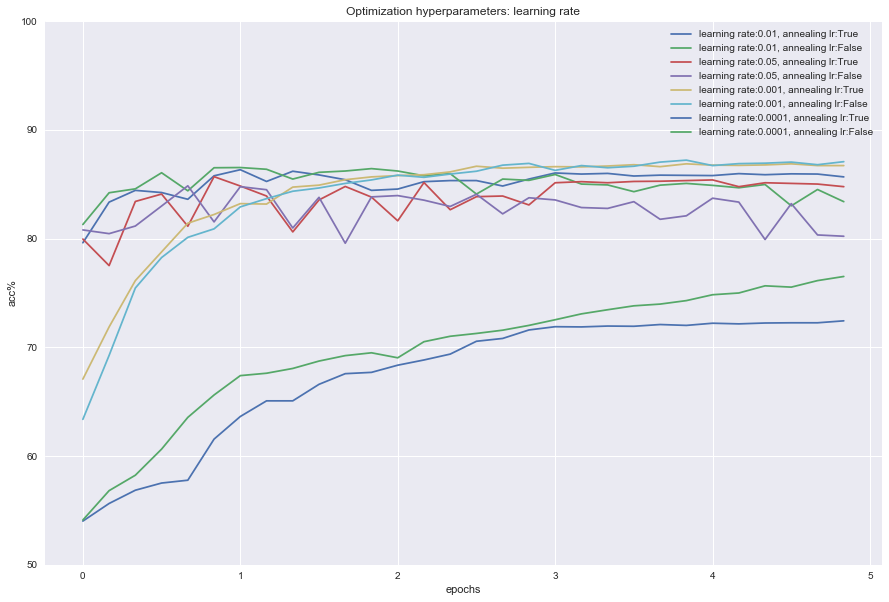

In [132]:
sns.set()

fig, ax = plt.subplots(figsize=(15,10))
l = locals()

x = np.arange(0 , 5, 1/6).reshape(-1,1)
for i in table.keys():
    y = table[i]
    label = 'learning rate:'+i.split(',')[0]+', annealing lr:'+i.split(',')[1]
    l[label],=ax.plot(x, y, label = label)
    
ax.legend(loc = 'best')
plt.title('Optimization hyperparameters: learning rate')
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50,100)
plt.savefig('figure/lr_acc.jpg')

plt.show()

### Plot training curves for the best model

In [33]:
import pickle as pkl
table= {}
train_loader, val_loader, test_loader = data_loader(1)

emb_dim = 500
model = BagOfWords(10002, emb_dim)
learning_rate = 0.001
num_epochs = 5 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_history = []
train_history = []
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            val_history.append(val_acc)
            train_history.append(train_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
test_acc = test_model(test_loader, model)

table['val_history'] = val_history
table['train_history'] = train_history
table['test_acc'] = test_acc

Epoch: [1/5], Step: [101/625], Validation Acc: 62.96
Epoch: [1/5], Step: [201/625], Validation Acc: 70.72
Epoch: [1/5], Step: [301/625], Validation Acc: 75.9
Epoch: [1/5], Step: [401/625], Validation Acc: 78.94
Epoch: [1/5], Step: [501/625], Validation Acc: 80.74
Epoch: [1/5], Step: [601/625], Validation Acc: 82.1
Epoch: [2/5], Step: [101/625], Validation Acc: 83.42
Epoch: [2/5], Step: [201/625], Validation Acc: 83.86
Epoch: [2/5], Step: [301/625], Validation Acc: 84.08
Epoch: [2/5], Step: [401/625], Validation Acc: 84.68
Epoch: [2/5], Step: [501/625], Validation Acc: 85.04
Epoch: [2/5], Step: [601/625], Validation Acc: 85.3
Epoch: [3/5], Step: [101/625], Validation Acc: 85.92
Epoch: [3/5], Step: [201/625], Validation Acc: 85.88
Epoch: [3/5], Step: [301/625], Validation Acc: 85.96
Epoch: [3/5], Step: [401/625], Validation Acc: 86.24
Epoch: [3/5], Step: [501/625], Validation Acc: 86.56
Epoch: [3/5], Step: [601/625], Validation Acc: 86.7
Epoch: [4/5], Step: [101/625], Validation Acc: 86.

In [34]:
pkl.dump(table, open('accuracy/acc_history.p', 'wb'))
pkl.dump(model, open('final_model.p', 'wb'))

In [35]:
print(pd.DataFrame(table))

    test_acc  train_history  val_history
0       85.5         63.355        62.96
1       85.5         71.550        70.72
2       85.5         77.740        75.90
3       85.5         80.885        78.94
4       85.5         82.965        80.74
5       85.5         84.215        82.10
6       85.5         85.800        83.42
7       85.5         86.750        83.86
8       85.5         87.275        84.08
9       85.5         88.220        84.68
10      85.5         88.755        85.04
11      85.5         89.435        85.30
12      85.5         90.040        85.92
13      85.5         90.320        85.88
14      85.5         90.540        85.96
15      85.5         91.275        86.24
16      85.5         91.520        86.56
17      85.5         91.725        86.70
18      85.5         91.945        86.82
19      85.5         92.270        86.84
20      85.5         92.680        86.96
21      85.5         92.855        86.74
22      85.5         92.895        86.92
23      85.5    

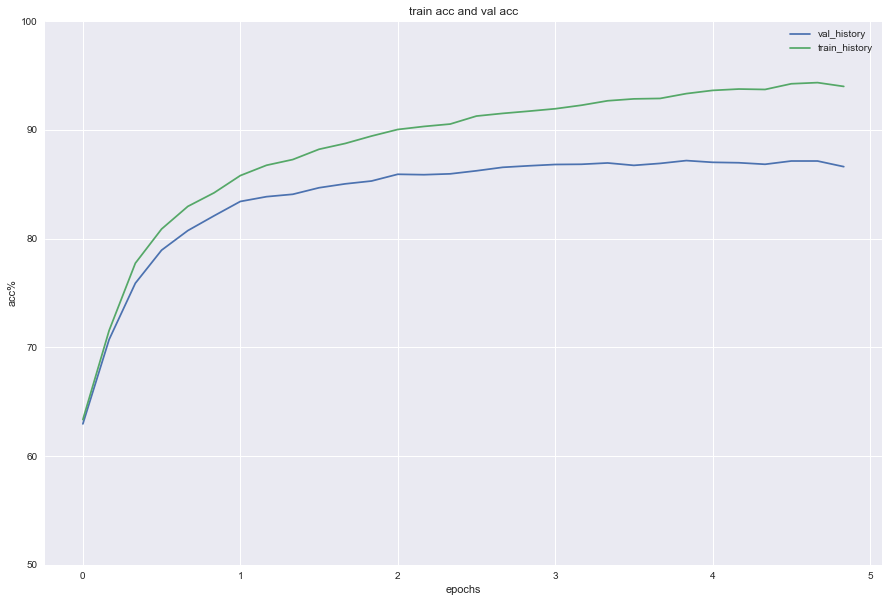

In [38]:
sns.set()
fig,ax=plt.subplots(figsize=(15,10))
l=locals()

x = np.arange(0 , 5, 1/6).reshape(-1,1)
for i in ['val_history','train_history']:
    l[i],=ax.plot(x, table[i], label=i)

ax.legend(loc = 'best')
plt.title('train acc and val acc')
plt.xlabel('epochs')
plt.ylabel('acc%')
plt.ylim(50,100)
plt.savefig('figure/acc_history.jpg')
plt.show()

In [39]:
print('test accuracy is: {}'.format(test_acc))

test accuracy is: 85.5


### Print several predictions

In [41]:
model

BagOfWords(
  (embed): Embedding(10002, 500, padding_idx=0)
  (linear): Linear(in_features=500, out_features=20, bias=True)
)

In [230]:
def prediction(loader, model):

    correct = 0
    total = 0
    model.eval()
    prediction = []
    label = []
    correct_pred = []
    incorrect_pred = []
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        equal = [x.item() for x in predicted.eq(labels.view_as(predicted))]
        for i in range(len(equal)):
            if equal[i] == 1:
                correct_pred.append([x.item() for x in data[i]])
            else:
                incorrect_pred.append([x.item() for x in data[i]])
                

    return correct_pred, incorrect_pred

In [231]:
correct_prediction, incorrect_prediction = prediction(val_loader, model)

In [236]:
len(correct_prediction), len(incorrect_prediction)

(4355, 645)

We randomly choose 5 correct predictions and 5 incorrect predictions

In [237]:
import random
correct_index = random.sample(range(len(correct_prediction)), 5)
incorrect_index = random.sample(range(len(incorrect_prediction)), 5)

In [253]:
for k, i in enumerate(correct_index):
    print('%s-th correct instance:'%str(k+1)+'\n'+' '.join([id2token[j] for j in correct_prediction[i] if id2token[j]!='<pad>']))

1-th correct instance:
i ended up watching this movie before even going through any of the reviews on the <unk> of a female just out of curiosity i thought let me find out if there are people who actually recommend others to watch this movie i am quite shocked to find such long and positive reviews on this website that makes me conclude that it 's a <unk> /><br />as far as my opinion goes i have to <unk> these filmmakers retarded or do they assume that the viewers are retarded the movie is atrocious on so many levels and i 'm not even talking about the story or <unk> /><br />so these bunch of guys plus one girl the lead actress form a music band guessing from the constant presence of <unk> it is supposed to be a rock band hell when did dancers started becoming the part of a rock band anyway let me accept it as the bollywood version of <unk> rock band but <unk> enough all the scores which actually had these two <unk> doing all kinds of cool rock gestures and i am assuming they were play

In [254]:
for k, i in enumerate(incorrect_index):
    print('%s-th incorrect instance:'%str(k+1)+'\n'+' '.join([id2token[j] for j in incorrect_prediction[i] if id2token[j]!='<pad>']))

1-th incorrect instance:
mark <unk> 's <unk> <unk> of 1987 is a black comedy that is extremely cheesy in many parts but occasionally very funny nevertheless this movie could certainly have been a lot better the acting is terrible and some extremely cheesy scenes make it hard to watch at times but the concept is funny and it has some hilarious <unk> /><br />in the near future the year 1991 game shows have changed chuck <unk> john <unk> <unk> <unk> a game show called live or die in which convicted death row inmates have the chance to play for their lives and for money <unk> who fail get executed on the air using many different methods such as <unk> electric <unk> and other more bizarre devices of execution followed by applause from the cheering studio audience the show is of course more than controversial and chuck has made lots of enemies ... <br /><br <unk> <unk> is incredibly cheesy and crappy in many aspects and the acting is terrible but it is without doubt fun in many parts especia

### Global Search

In [ ]:
table = {}
for i in n_gram:
    print('n_gram:',i)
    train_loader, val_loader, test_loader = data_loader(i)
    table[i] = []
    for opt in optimizers:
        train_history, val_history, test_acc = compare_model(train_loader, val_loader, test_loader, optimizer_name = opt,print_ = False )
        print('optimizers:%s, train accuracy:%.2f, test accuracy:%.2f, val accuracy:%.2f'%(opt, max(train_history), max(val_history),test_acc ))
        table[i].append({'n_gram': i, 'optimizers':opt,'val_history':val_history,'val_acc':max(val_history), 'train_history':train_history, 'train_acc':max(train_history), 'test_acc' :test_acc} )
    for vs in vocab_sizes:
        train_history, val_history, test_acc = compare_model(train_loader, val_loader, test_loader, vocab_size = vs,print_ = False )
        print('vocab_sizes:%s, train accuracy:%.2f, test accuracy:%.2f, val accuracy:%.2f'%(vs, max(train_history), max(val_history),test_acc ))
        table[i].append({'n_gram': i, 'vocab_size':vs,'val_history':val_history,'val_acc':max(val_history), 'train_history':train_history, 'train_acc':max(train_history),'test_acc' :test_acc} )
    for lr in learning_rates:
        val_history, test_acc = compare_model(train_loader, val_loader, test_loader, learning_rate = lr,print_ = False )
        print('learning rate:%s, train accuracy:%.2f, test accuracy:%.2f, val accuracy:%.2f'%(lr, max(train_history), max(val_history),test_acc ))
        table[i].append({'n_gram': i, 'learning_rate':lr,'val_history':val_history,'val_acc':max(val_history), 'test_acc' :test_acc} )
    for ed in embed_dims:
        val_history, test_acc = compare_model(train_loader, val_loader, test_loader, emb_dim = ed,print_ = False )
        print('learning rate:%s, train accuracy:%.2f, test accuracy:%.2f, val accuracy:%.2f'%(lr, max(train_history), max(val_history),test_acc ))
        table[i].append({'n_gram': i, 'emb_dim':ed,'val_history':val_history,'val_acc':max(val_history), 'test_acc' :test_acc} )
    val_history, test_acc = compare_model(train_loader, val_loader, test_loader, annealing_learing = True,print_ = False )
    table[i].append({'n_gram': i, 'annealing_learing':True,'val_history':val_history,'val_acc':max(val_history), 'test_acc' :test_acc})
    df = pd.DataFrame(table[i])
    df.emb_dim = df.emb_dim.fillna(500)
    df.learning_rate = df.learning_rate.fillna(0.001)
    df.vocab_size = df.vocab_size.fillna(10002)
    df.optimizers = df.optimizers.fillna('Adam')
    df.annealing_learing = df.annealing_learing.fillna(True)
    df.to_csv('table_%s_gram.csv'%i)
    
    
    